In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum

In [2]:
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [3]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['TSLA', 'AAPL', 'IBM', 'AMZN', 'MMM',
           'ABMD', 'ACN', 'APD', 'GOOGL', 'BLK']



In [4]:
BETA_TYPE = BetaType.NO
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30
INITIAL_CASH = 500000

In [5]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [6]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [7]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

In [8]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.std(ddof=lag)

In [9]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean, lags=lag, # mean = Constant, ARX, HARX + the number of lags
                       vol=vol, p=p, o=o, q=q, # vol = Garch, EGARCH, HARCH + the number of lags
                       dist=dist) # dist = Normal, t, skewstudent, ged

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    varis = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, varis

In [10]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS)
        net_market_returns_f[ticker] = fltr_res[GARCH_LAG:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

In [11]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [76]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
    return pd.DataFrame(alphas, columns=tickers, index=real_returns.index)

In [13]:
def alpha(mu, real_return):
    return 2 * mu - real_return



In [14]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
rp_df.tail(1)

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2017-12-29,62.27,40.783367,135.013367,1169.469971,215.700958,187.410004,146.729187,154.349213,1053.400024,476.534546


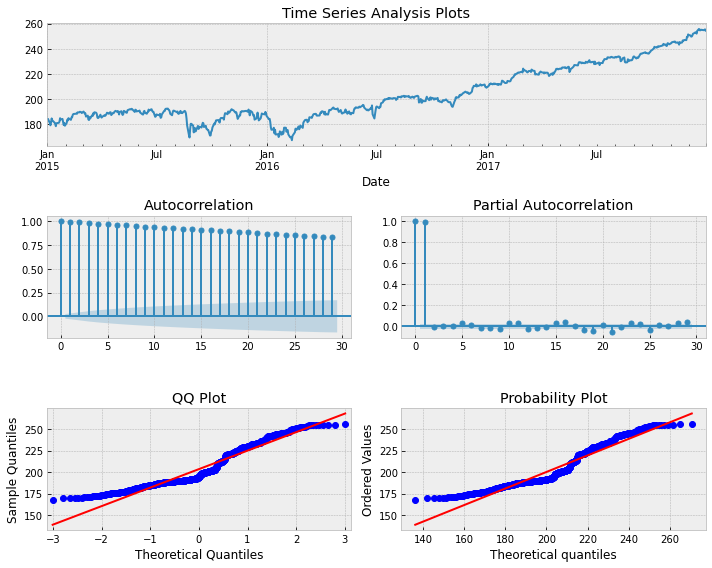

In [16]:
tsplot(spy_p)

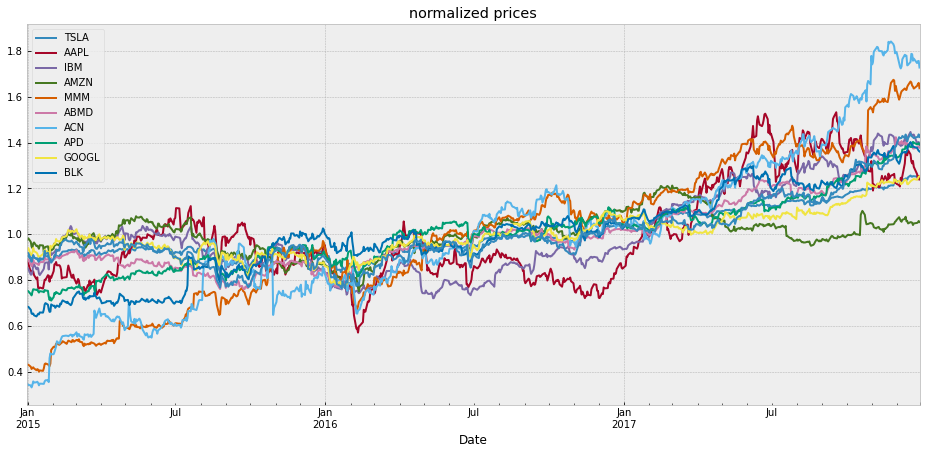

In [17]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for _, data in rp_df.iteritems():
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

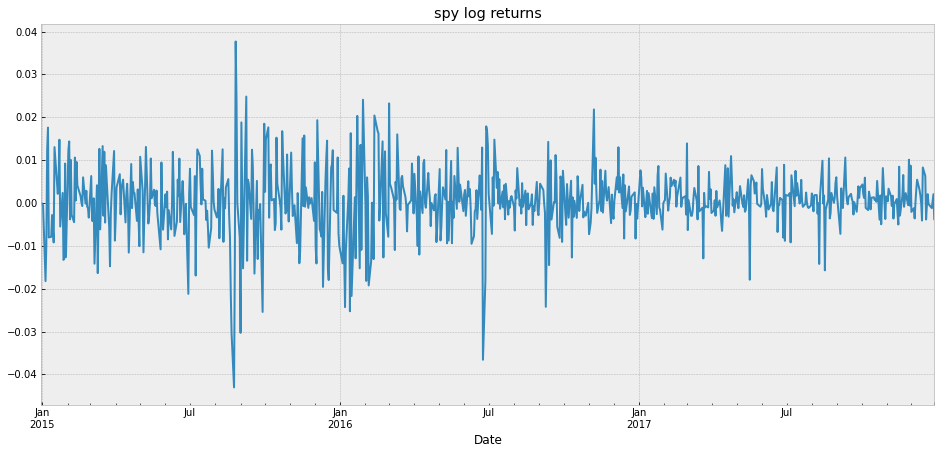

In [18]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

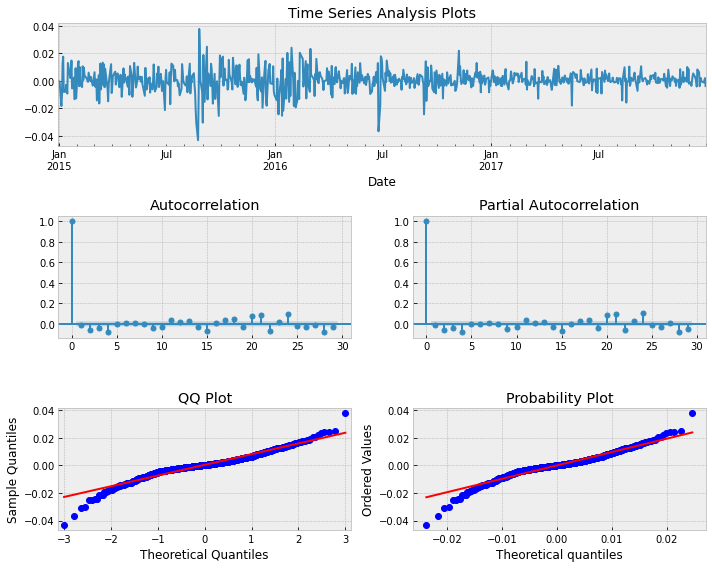

In [19]:
tsplot(spy)

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


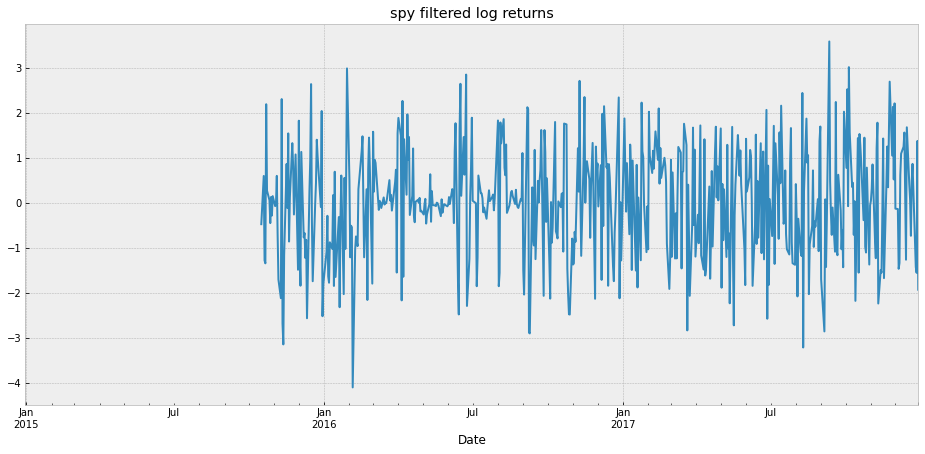

In [20]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

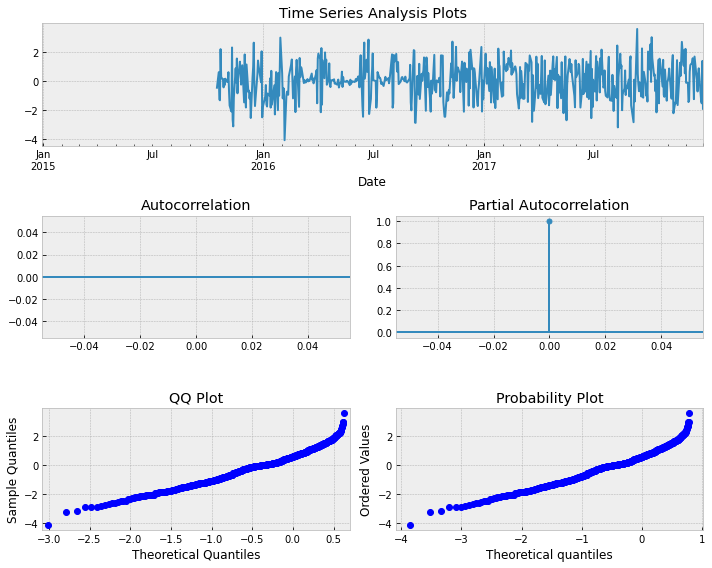

In [21]:
tsplot(spyf)

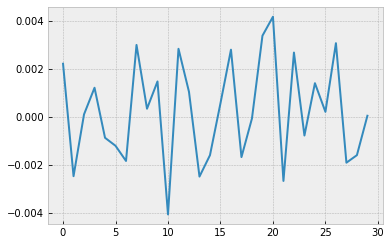

In [22]:
spy_means.plot()
plt.show()

<Figure size 1152x504 with 0 Axes>

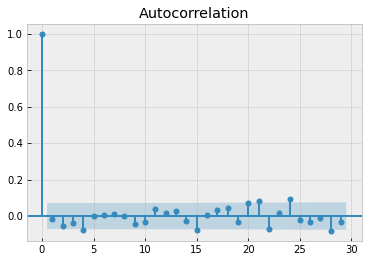

In [23]:
plt.figure(figsize=(16,7))
plot_acf(spy)
plt.show()


<Figure size 1152x504 with 0 Axes>

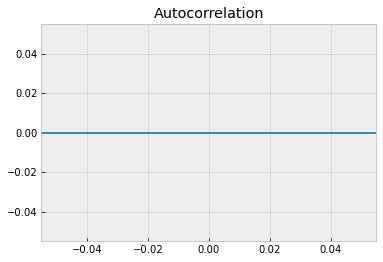

In [24]:
plt.figure(figsize=(16,7))
plot_acf(spyf)
plt.show()

In [25]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.920002
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -23.271459
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [26]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

In [27]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS)
        filtered_returns[ticker] = fltr_res[GARCH_LAG:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

Wall time: 0 ns


{'TSLA': 0,
 'AAPL': 0,
 'IBM': 0,
 'AMZN': 0,
 'MMM': 0,
 'ABMD': 0,
 'ACN': 0,
 'APD': 0,
 'GOOGL': 0,
 'BLK': 0}

In [75]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-02,-0.014036,-0.009558,0.010047,-0.005914,-0.001584,-0.019902,-0.005276,0.008285,-0.002094,-0.002324
2015-01-05,-0.042950,-0.028576,-0.015860,-0.020731,-0.022811,-0.006453,-0.017029,-0.032496,-0.019238,-0.026215
2015-01-06,0.005648,0.000094,-0.021802,-0.023098,-0.010721,-0.025684,-0.007240,-0.000355,-0.024989,-0.015661
2015-01-07,-0.001563,0.013925,-0.006557,0.010544,0.007222,0.031333,0.020773,0.010743,-0.002945,0.020943
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.019670,0.000000,0.006579,-0.005463,-0.000213,0.005284,-0.002012,0.001592,-0.001860,-0.002866
2017-12-26,-0.024624,-0.025697,0.002162,0.007164,0.003063,-0.011019,-0.005866,-0.002573,-0.002820,0.003119
2017-12-27,-0.017968,0.000176,0.001961,0.004663,0.003180,0.004632,0.002155,0.004102,-0.005315,0.001167


In [39]:
%%time
today = 2 * GARCH_LAG + 1
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[(today - 2 * GARCH_LAG - 1): today])#fixme check

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize

Wall time: 927 ms


C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [40]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

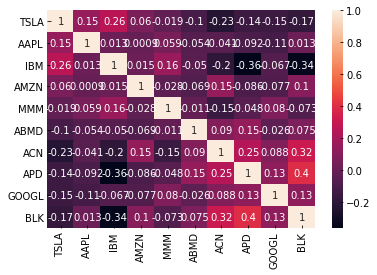

In [41]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [99]:
def trade(alphas, positions, pv_series, prices):
    pv = positions['CASH']
    if pv < 0:
        print("Negative PV! ", pv, " at ", len(pv_series))
    for ticker in tickers:
        pv = pv + positions[ticker] * prices[ticker]
    pv_series.append(pv)
    expected_positions = alphas.iloc[0] * pv
    for ticker in tickers:
        amount = (expected_positions[ticker] - positions[ticker]) * prices[ticker]
        print(amount)
        positions['CASH'] = positions['CASH'] - amount * 1.01
        positions[ticker] = expected_positions[ticker]
    

In [98]:
positions = {}
for ticker in tickers:
    positions[ticker] = 0
positions['CASH'] = INITIAL_CASH

alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
normalized_alphas = (alphas / alphas.to_numpy().sum())

expected_positions = alphas.iloc[0] * 100

expected_positions

TSLA     -318.196279
AAPL      829.863823
IBM        -1.376141
AMZN     4608.039433
MMM      -501.664085
ABMD      101.774180
ACN       -40.378821
APD        52.626772
GOOGL    3519.415761
BLK      6915.875968
Name: TSLA, dtype: float64

In [ ]:
positions = {}
for ticker in tickers:
    positions[ticker] = 0
positions['CASH'] = INITIAL_CASH
    
pv_series = [0]
last_refit_date = GARCH_LAG * 2 + 1
while last_refit_date < len(rp_df):
    nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[: last_refit_date])#fixme check
    corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
    for offset in range(0, GARCH_REFIT_DELAY_DAYS):
        today = last_refit_date + offset + 1
        alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
        normalized_alphas = (alphas / alphas.to_numpy().sum())
        trade(normalized_alphas, positions, pv_series, nmkt_rets_df.iloc[today])
    last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS
    


C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize

2.6156192252407524
-25.210677828829045
1.553388124324102
236.27595099066392
-0.8182472219323075
0.695266168894177
-2.046828014483596
2.541268919456668
-5.905926214613913
393.9711219586158
0.15047872733360615
36.3043304948592
0.04960266686238821
-14.722003275046045
-0.08167446409133498
0.03389108265257202
-1.0446289266603321
4.927031492844402
-25.467257983161776
-45.88086727853251
3.895652966271392
-19.999491619398775
0.06690689807872344
-32.62015306439493
-2.1635309974060664
-12.361531221007132
-0.5908435648940173
1.5948268787981135
-134.6669568914099
-533.15879131673
-2.013471402510444
-25.018705658027496
0.095572038471234
-0.10855198630935564
-3.958635354571705
0.15502976570842683
0.14844919666012188
0.2539743643423993
131.0842288856713
637.6059145708863
-2.0486859815863205
0.7457420226518892
-0.04748975438164606
-1.8436422803071142
15.330666981578828
0.043540451376282034
-0.00018583894630624822
-0.044746222984632184
6.926272952050563
50.225720375733005
-0.04090841017222948
0.0107243

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


-1.7544683322473882
25.23545730991631
0.20000162186664538
0.7495875425958944
1.0331519586520066
18.380158480875924
17.540925143778253
238.48252288176005
157.0841940276649
-2.421083933161203
-3.74642983525305
-1.0575587274557503
1.6966018193652184
5.883058291087978
1.1363312708341096
0.0
32.38414661533296
-47.16931867995114
-56.932442672874885
-27.78448269053398
0.8528444233312158
0.19599599438603982
-1.78668928406282
-7.875661681158867
2.7601271353113823
-25.858585764153357
51.26356436417314
-14.071108109123987
-4.719983161836843
-5.105494034041377
-145.33231082118476
7615.09387143345
-113.6812399957384
-1273.5578301683195
-66.26614415448007
-308.3436081717774
13338.27240248773
6565.455294415153
-1412.2169023668034
2569.6530271249712
124.73097900457768
13532.93749205785
-223.59540926712245
88.38803038168123
-631.6185050898602
1827.0616386710788
3874.4923674437505
-7709.777557513886
-131.89572942470573
6182.851883270135
-10.880671276399122
-17.732798924987335
-1.2246838214516884
1.30809

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


641.8683944146159
-16.195170999173882
-5.2719087236537145
57.29249840127057
-38.779900798417614
-78.34423748091565
-80.91531047862344
25.731429405772396
31.71282390107653
-1.5931588294348242
-2294.289385778717
48.091042818243814
4.210895818958458
6.8423606089419255
78.0589162623873
-259.09058435836744
0.15417465734946173
113.43832906230077
-0.5987559994927079
-1.4380797926088744
89.49774805697724
-2.8475369125138865
-1.8746777324371733
-0.8559867317819744
2.426283097487966
-131.5618132870091
0.45052764497999115
1.9692844186729492
-0.7047950310523852
2.4754327625251737
14.920688674189087
147.60809458482478
0.2163517339203912
0.39554267397118764
-6.064785364171085
-350.66146850268154
9.77268962006161
8.011596021968364
5.526208454486568
6.376942317908208
-2.8391434710211647
77.07686411422299
0.23327101336097797
2.1002360411453043
2.6691246609574835
254.6200306532044
-2.294632636601299
-5.379387764141016
-0.5567863288234322
10.27002137144353
128.15595742552944
381.0591982945064
-23.6395146

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
pv_s = pd.Series(pv_series)
pv_s.plot()

<AxesSubplot:>

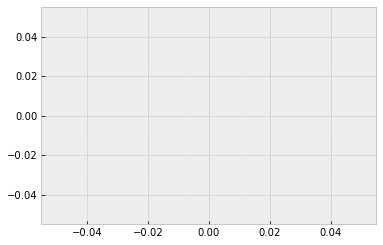

In [49]:
pnl = pv_s.diff()
pnl.plot()

In [50]:
pnl.min()

nan